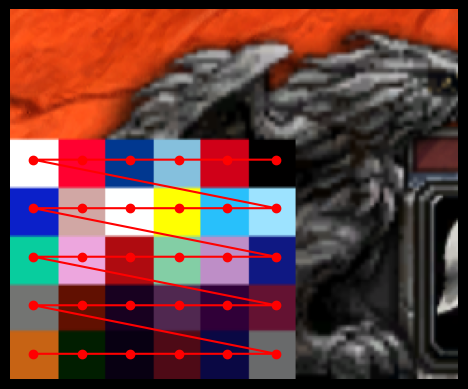

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img = Image.open('screenshot1.png')
#d_crop = 200
#img = img.crop((0, img.height - d_crop, d_crop, img.height))
H,W = img.height, img.width

# read control pixel, which is the absolute bottom left of the image
bottom_left_corner = complex(0, H - 1)
control_pixel = img.getpixel((bottom_left_corner.real, bottom_left_corner.imag))
_,_,_,_ = control_pixel

# determine cell size by starting at the bottom left corner and moving right until the value changes
def determine_cell_size():
    cell_size = 1
    while True:
        a,b,c,_ = img.getpixel((bottom_left_corner.real + cell_size, bottom_left_corner.imag))
        if a != control_pixel[0] or b != control_pixel[1] or c != control_pixel[2]:
            return cell_size + 1
        cell_size += 1

cell_size = determine_cell_size()

prev_pos = []
read_values = []

reader_pos = bottom_left_corner + complex(cell_size//2-1, -cell_size//2+1)
prev_pos.append(reader_pos)
dir_right = complex(cell_size-1, 0)

def move_right():
    global reader_pos, prev_pos
    reader_pos += dir_right
    a,b,c,_ = img.getpixel((reader_pos.real, reader_pos.imag))
    read_values.extend([a,b,c])
    prev_pos.append(reader_pos)

def reset_next_line():
    global reader_pos, prev_pos
    reader_pos = complex(cell_size//2-1, reader_pos.imag - (cell_size-1))
    a,b,c,_ = img.getpixel((reader_pos.real, reader_pos.imag))
    read_values.extend([a,b,c])
    prev_pos.append(reader_pos)


move_right()
meta_pixel = img.getpixel((reader_pos.real, reader_pos.imag))
channel_remainder, least_significant, most_significant, _ = meta_pixel
grid_size = least_significant + most_significant * 256
grid_side_length = int(np.round(np.sqrt(grid_size)))

for r in range(grid_side_length):
    for c in range(grid_side_length):
        if r == 0 and c < 1:
            continue
        if len(read_values) // 3 >= grid_size-1:
            break
        move_right()
    
    # on every iteration except the last one, reset the next line
    if r < grid_side_length - 1:
        reset_next_line()


plt.imshow(img)
plt.plot([p.real for p in prev_pos], [p.imag for p in prev_pos], 'ro-')
plt.axis('off')
plt.show()

In [5]:
for i in range(3,len(read_values),3):
    print(read_values[i], end=' ')
    print(read_values[i+1], end=' ')
    print(read_values[i+2])

8 0 18
78 10 22
10 8 68
105 106 107
115 116 114
97 16 1
24 1 32
80 40 80
48 0 56
100 18 50
8 205 158
237 166 222
175 11 16
131 206 165
190 142 199
15 24 131
11 32 201
209 167 164
254 255 255
255 255 1
40 192 251
157 227 255
255 255 255
255 1 48
1 56 144
133 192 221
208 0 24
1 0 0


In [9]:
print(read_values[3:offset_map[channel_remainder]])
print([8, 0, 18, 78, 10, 22, 10, 8, 68, 105, 106, 107, 115, 116, 114, 97, 16, 1, 24, 1, 32, 80, 40, 80, 48, 0, 56, 100, 18, 50, 8, 205, 158, 237, 166, 222, 175, 11, 16, 131, 206, 165, 190, 142, 199, 15, 24, 131, 11, 32, 201, 209, 167, 164, 254, 255, 255, 255, 255, 1, 40, 192, 251, 157, 227, 255, 255, 255, 255, 255, 1, 48, 1, 56, 144, 133, 192, 221, 208, 0, 24, 1, 0, 0, 138])

[8, 0, 18, 78, 10, 22, 10, 8, 68, 105, 106, 107, 115, 116, 114, 97, 16, 1, 24, 1, 32, 80, 40, 80, 48, 0, 56, 100, 18, 50, 8, 205, 158, 237, 166, 222, 175, 11, 16, 131, 206, 165, 190, 142, 199, 15, 24, 131, 11, 32, 201, 209, 167, 164, 254, 255, 255, 255, 255, 1, 40, 192, 251, 157, 227, 255, 255, 255, 255, 255, 1, 48, 1, 56, 144, 133, 192, 221, 208, 0, 24, 1]
[8, 0, 18, 78, 10, 22, 10, 8, 68, 105, 106, 107, 115, 116, 114, 97, 16, 1, 24, 1, 32, 80, 40, 80, 48, 0, 56, 100, 18, 50, 8, 205, 158, 237, 166, 222, 175, 11, 16, 131, 206, 165, 190, 142, 199, 15, 24, 131, 11, 32, 201, 209, 167, 164, 254, 255, 255, 255, 255, 1, 40, 192, 251, 157, 227, 255, 255, 255, 255, 255, 1, 48, 1, 56, 144, 133, 192, 221, 208, 0, 24, 1, 0, 0, 138]


In [6]:
from Lakeshire_pb2 import GameState

offset_map = {
    0: len(read_values),
    1: -2,
    2: -1
}

game_state = GameState()
game_state.ParseFromString(bytes(read_values[3:offset_map[channel_remainder]]))
#game_state.ParseFromString(bytes([8, 0, 18, 78, 10, 22, 10, 8, 68, 105, 106, 107, 65, 67, 65, 115, 116, 114, 97, 16, 1, 24, 1, 32, 80, 40, 80, 48, 0, 56, 100, 18, 50, 8, 205, 158, 237, 166, 222, 175, 11, 16, 131, 206, 165, 190, 142, 199, 15, 24, 131, 11, 32, 201, 209, 167, 164, 254, 255, 255, 255, 255, 1, 40, 192, 251, 157, 227, 255, 255, 255, 255, 255, 1, 48, 1, 56, 144, 133, 192, 221, 208, 0, 24, 1]))
print(game_state)

BotState: Stopped
Player {
  UnitInfo {
    Name: "Dijkstra"
    Level: 1
    Class: Warrior
    HealthCurrent: 80
    HealthMax: 80
    PowerCurrent: 0
    PowerMax: 100
  }
  PosInfo {
    MapX: 50018733739853
    MapY: 68414127826691
    MapId: 1411
    WorldX: -460724023
    WorldY: -60326464
    InstanceId: 1
    Facing: 21670920848
  }
  Flags: 1
}

